In [4]:
# imports
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
import os

## Load data

In [5]:
# load data
root = os.getcwd()
dataset_dir = os.path.join(root, 'Data_60')

In [6]:
raw_df = pd.DataFrame()

# Raw dataframe

We build a dataframe containing time signals with additional noise

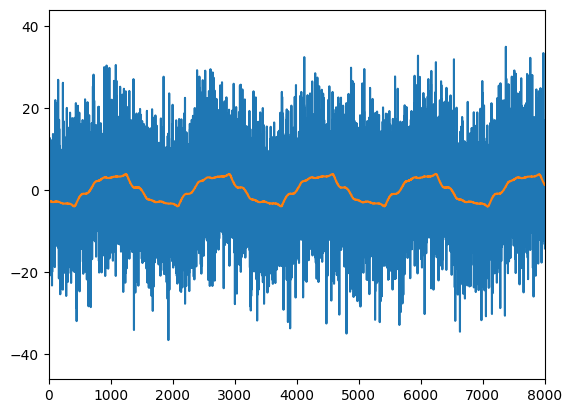

,label,time_sig
0,Fun,"[10.762277329025085, -13.800514393357597, -18...."
1,Fun,"[-7.299903288599264, -9.718446853073297, 7.947..."
2,Fun,"[-15.078017464967937, 3.746740339044833, -5.01..."
3,Fun,"[3.9257464040530854, 32.09650511659171, -0.720..."
4,Fun,"[-0.9464446905622228, -10.714427472836704, 3.2..."


In [121]:
# Initialize an empty list to store data
data_list = []

list_of_folders = os.listdir(dataset_dir)

fs  = 1/100000 #Hz
n_harmonics = 200
noise = 10

first_iter = True
# Read matlab files
for folder in list_of_folders:
    path = os.path.join(dataset_dir, folder)
    list_of_files = os.listdir(path)
    label = str(folder)
    for file in list_of_files:
        if file.endswith('.mat'):
            # Read matlab file
            mat = scipy.io.loadmat(os.path.join(path, file))

            # Get data and append to the list
            t_sig = mat['tpd']['Data'][0][0][0] + np.random.normal(0, noise, len(mat['tpd']['Data'][0][0][0]))
            # ft =np.fft.fft(t_sig)
            if first_iter:
                freqs = np.fft.fftfreq(len(t_sig), fs)
                #h_index = np.where(freqs % 60 == 0)[0]
                #print("harmonics indicies", h_index)


                plt.figure()
                plt.plot(t_sig)
                plt.plot(mat['tpd']['Data'][0][0][0])
                plt.xlim(0, 8000)
                plt.show()

                
                # fc_low = 57
                # fc_high = 63
                # w = np.zeros(len(freqs))
                # w[np.where(fc_high<freqs)] = 1
                # w[np.where(freqs<fc_low)] = 1
                first_iter = False
            # ft_cut =  ft*w
            # abs_ft_cut_norm = abs(ft_cut/np.linalg.norm(ft_cut)) + 1e-10
            
            # harmo = np.log(abs_ft_cut_norm[h_index][2:n_harmonics] + 1e-10)
            # pick_afftn = abs_ft_cut_norm[np.argsort(abs_ft_cut_norm)[0:30]]
            data_list.append({'label': label, 
                              'time_sig': t_sig})

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data_list)

df.head()

## Training dataframe

We build a dataframe containing mixture of signals and corresponding vector of 0 and 1 to identify presence of signals. We also add the feature harmonic to every time signal. This will be used to train model on a smaller representation of the signal. And we add the spectrum feature to try some training on it.

In [122]:
np.random.seed(42)
N = 5*60 #number of training examples

freqs = np.fft.fftfreq(len(df['time_sig'][0]), fs) #list of frequences

list_train_signal = []
labels = df['label'].unique()
feature_size = len(df['time_sig'][0])
min_nb_labels = df['label'].value_counts().min()

for i in range(N):
    random_selection = np.random.randint(0,2, len(labels))
    mix = np.zeros(feature_size)
    present_labels = np.zeros(labels.shape)
    for i,label in enumerate(labels):
        if random_selection[i] == 1:
            mix += df['time_sig'][df['label']==label].iloc[np.random.randint(0, min_nb_labels)]
            present_labels[i] = 1
    
    # spectrum 
    ft =np.fft.fft(mix)
    fc_low = 57 #Hz
    fc_high = 63 #Hz
    w = np.zeros(len(freqs))
    w[np.where(fc_high<freqs)] = 1
    w[np.where(freqs<fc_low)] = 1
    ft_cut =  ft*w # filtering the 60Hz 

    abs_ft_cut_norm = abs(ft_cut/(np.linalg.norm(ft_cut) + 1e-10))
    h_index = np.where(freqs % 60 == 0)[0]
    harmo = np.log(abs_ft_cut_norm[h_index][2:n_harmonics] + 1e-10)
    if np.isnan(harmo).any(): print(np.isnan(harmo).sum())
    list_train_signal.append({'time_sig': mix, 'harmonics' : harmo ,'spectrum' : np.log(abs_ft_cut_norm+ 1e-10), 'label': present_labels})

df_train = pd.DataFrame(list_train_signal)
df_train.head(5)

,time_sig,harmonics,spectrum,label
0,"[-4.091078096377171, 6.9181109765064726, -12.7...","[-4.929720250504239, -2.8044103671969163, -5.3...","[-5.9930836581100335, -5.083242259902648, -5.9...","[0.0, 1.0, 0.0, 0.0, 0.0]"
1,"[-22.210449849691077, 7.071731469311137, 2.146...","[-4.940864250854102, -4.678635226769958, -4.97...","[-4.553881201348749, -4.648540858811401, -5.55...","[0.0, 0.0, 0.0, 1.0, 0.0]"
2,"[11.430734204751776, -35.07594632295645, 4.457...","[-3.0598919520395604, -5.441377972484012, -4.2...","[-5.645547366287367, -4.683718042452297, -5.46...","[0.0, 0.0, 1.0, 0.0, 1.0]"
3,"[-3.1476544455942848, -0.31395270978745415, 5....","[-5.197289701821986, -3.1649080218123062, -6.1...","[-4.20995044414943, -5.562347670031958, -6.619...","[0.0, 1.0, 0.0, 1.0, 1.0]"
4,"[-7.396388307734856, -9.127420650359308, -9.10...","[-3.1773515312591165, -3.1263931594391217, -4....","[-6.850024401110753, -6.287582438298548, -5.37...","[1.0, 1.0, 1.0, 0.0, 0.0]"


Text(0.5, 1.0, 'Signal captured : \n Fun + hairdryer + lightbulb')

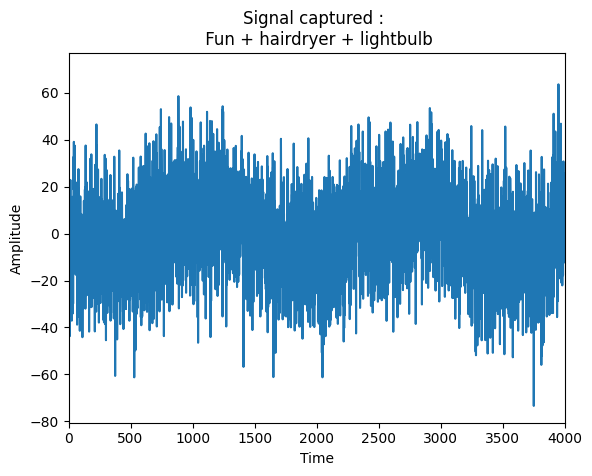

In [133]:
# visualize one mixture signal
plt.plot(df_train['time_sig'][21])
xlim = plt.xlim(0, 4000)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Signal captured : \n Fun + hairdryer + lightbulb')

# train test split

In [136]:
from sklearn.model_selection import train_test_split

feature = 'time_sig' # choose the feature to train on : 'time_sig', 'harmonics', 'spectrum'

feature_size = len(df_train[feature][0])
X= np.array(df_train[feature].tolist())
y = np.array(df_train['label'].tolist())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

print(X_train.shape)
print(y_train.shape)

(150, 20000)
(150, 5)


### Metrics

In [10]:
# f1 score 
from sklearn.metrics import f1_score

# Multi logistic regressions

accuracy for Fun = 0.47333333333333333 ||| f1 score Fun = 0.6425339366515836
accuracy for HairDryer = 0.4866666666666667 ||| f1 score HairDryer = 0.6280193236714976
accuracy for Heater = 0.54 ||| f1 score Heater = 0.6790697674418604
accuracy for LightBulb = 0.5466666666666666 ||| f1 score LightBulb = 0.7068965517241379
accuracy for Refrigerator = 0.4666666666666667 ||| f1 score Refrigerator = 0.6330275229357799
average accuracy = 0.5026666666666667
average f1 score = 0.6579094204849719


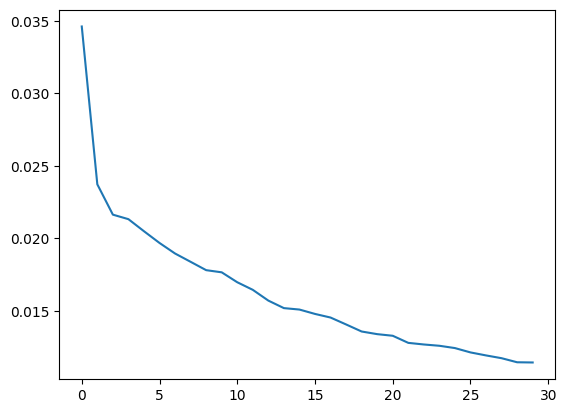

In [140]:
#buidling the model
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

pca = PCA(n_components=30)



avg_acc = 0
avg_f1 = 0

Xtrain_pca = pca.fit_transform(X_train)
eigen_values = pca.explained_variance_ratio_
plt.plot(eigen_values)
V = pca.components_
Xtest_pca = np.dot(X_test, V.T)
for i,label in enumerate(labels):
    y_label_train = y_train[:,i]
    y_label_test = y_test[:,i]
    
    model = LogisticRegression()
    model.fit(Xtrain_pca, y_label_train)
    
    ypred = model.predict(Xtest_pca)
    avg_acc += accuracy_score(y_label_test, ypred)
    avg_f1 += f1_score(y_label_test, ypred)
    print(f'accuracy for {label} = {accuracy_score(y_label_test, ypred)} ||| f1 score {label} = {f1_score(y_label_test, ypred)}')


print(f'average accuracy = {avg_acc/len(labels)}')
print(f'average f1 score = {avg_f1/len(labels)}')



# Convolution 1D

In [125]:
import keras.backend as K
def rmse(predictions, targets):
    return K.sqrt(K.mean((predictions-targets)**2))

In [129]:
# convolution 1d network
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten


model = Sequential()
model.add(Conv1D(filters=4, kernel_size=9,activation='relu', input_shape=(feature_size,1)))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(filters=8, kernel_size=9, activation='relu', input_shape=(feature_size,1)))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(filters=8, kernel_size=9, activation='relu', input_shape=(feature_size,1)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(5, activation='sigmoid'))

model.compile(loss=rmse, optimizer='adam', metrics=['accuracy', rmse])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 19992, 4)          40        
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 4998, 4)          0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 4990, 8)           296       
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 1247, 8)          0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 1239, 8)           584       
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 309, 8)          

Epoch 1/15
5/5 [==============================] - 4s 367ms/step - loss: 0.6441 - accuracy: 0.2533 - rmse: 0.6450 - val_loss: 0.6266 - val_accuracy: 0.0667 - val_rmse: 0.6261
Epoch 2/15
5/5 [==============================] - 1s 234ms/step - loss: 0.6113 - accuracy: 0.2467 - rmse: 0.6128 - val_loss: 0.6333 - val_accuracy: 0.5067 - val_rmse: 0.6331
Epoch 3/15
5/5 [==============================] - 1s 225ms/step - loss: 0.5658 - accuracy: 0.5133 - rmse: 0.5617 - val_loss: 0.5715 - val_accuracy: 0.1467 - val_rmse: 0.5719
Epoch 4/15
5/5 [==============================] - 1s 250ms/step - loss: 0.5087 - accuracy: 0.3400 - rmse: 0.5087 - val_loss: 0.5421 - val_accuracy: 0.2600 - val_rmse: 0.5440
Epoch 5/15
5/5 [==============================] - 1s 262ms/step - loss: 0.4503 - accuracy: 0.3467 - rmse: 0.4507 - val_loss: 0.5334 - val_accuracy: 0.1867 - val_rmse: 0.5344
Epoch 6/15
5/5 [==============================] - 1s 250ms/step - loss: 0.3843 - accuracy: 0.4000 - rmse: 0.3852 - val_loss: 0.500

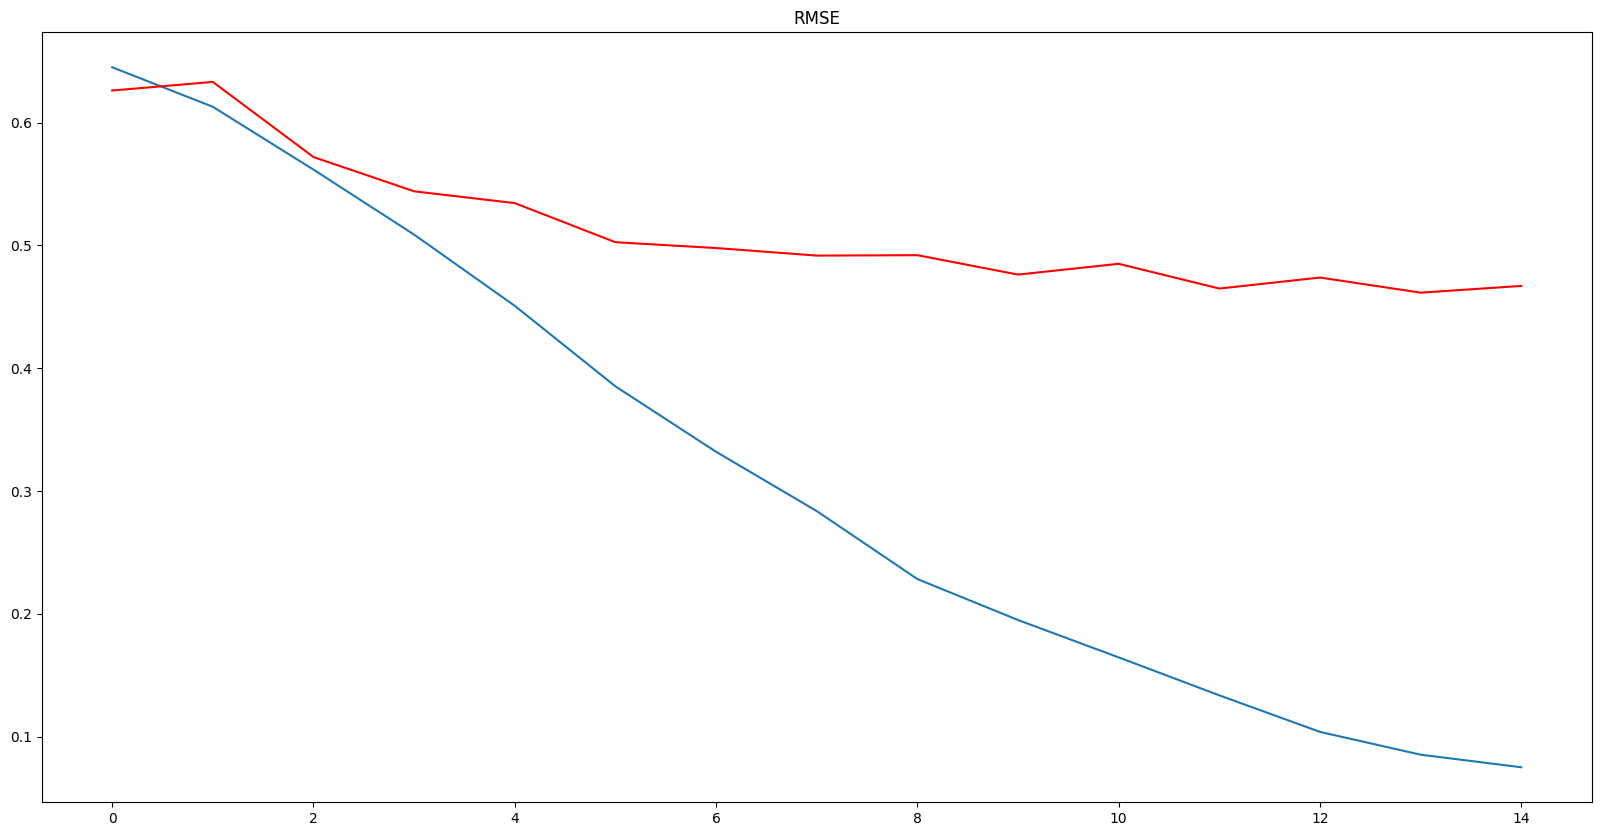

In [130]:
history = model.fit(X_train, y_train, epochs=15, verbose=1, validation_data=(X_test, y_test))
plt.figure(figsize=(20,10))
plt.title('RMSE')
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'], c='r')
avg = 0
avg_f1 = 0
ypred = model.predict(X_test)
for i,label in enumerate(labels):
    ypred_label = ypred[:,i].round()
    ytest_label = y_test[:,i]
    print(f'accuracy for {label} = {accuracy_score(ytest_label, ypred_label)}, || f1 score = {f1_score(ytest_label, ypred_label)}')
    avg += accuracy_score(ytest_label, ypred_label)
    avg_f1 += f1_score(ytest_label, ypred_label)
print(f'average accuracy = {avg/len(labels)}')
print(f'average f1 score = {avg_f1/len(labels)}')

# SVM 

In [135]:
#svm model
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


avg_acc = 0
avg_f1 = 0
for i,label in enumerate(labels):
    y_train_label = y_train[:,i]
    y_test_label = y_test[:,i]
    model = SVC(kernel='rbf', gamma=0.001, C=100)
    model.fit(X_train, y_train_label)

    ypred = model.predict(X_test)
    avg_acc += accuracy_score(y_test_label, ypred)
    avg_f1 += f1_score(y_test_label, ypred)
    print(f'accuracy for {label} = {accuracy_score(y_test_label, ypred)}, | f1 score = {f1_score(y_test_label, ypred)}')

print(f'average accuracy = {avg_acc/len(labels)}')
print(f'average f1 score = {avg_f1/len(labels)}')

accuracy for Fun = 0.5666666666666667, | f1 score = 0.5859872611464968
accuracy for HairDryer = 0.8466666666666667, | f1 score = 0.847682119205298
accuracy for Heater = 0.92, | f1 score = 0.918918918918919
accuracy for LightBulb = 0.52, | f1 score = 0.5263157894736842
accuracy for Refrigerator = 0.58, | f1 score = 0.5190839694656489
average accuracy = 0.6866666666666668
average f1 score = 0.6795976116420094
